### 1. Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pylab as pl
import plotly.express as px

In [2]:
%matplotlib inline

In [3]:
path = '/Users/timovic/Desktop/Climate Analysis - battle station/02 Data'

In [4]:
df = pd.read_pickle(os.path.join(path, 'Prepared Data', 'merged_all.pkl'))

In [5]:
df.shape

(6045, 9)

In [6]:
df.head()

country  year    hdi          gni  co2_consumption  happiness  \
0  Afghanistan  1990  0.273  2684.550019              NaN        NaN   
1  Afghanistan  1991  0.279  2276.289409              NaN        NaN   
2  Afghanistan  1992  0.287  2059.868084              NaN        NaN   
3  Afghanistan  1993  0.297  1525.533426              NaN        NaN   
4  Afghanistan  1994  0.292  1087.961890              NaN        NaN   

  hdi_groups undp_regions happiness category  
0        Low           SA                NaN  
1        Low           SA                NaN  
2        Low           SA                NaN  
3        Low           SA                NaN  
4        Low           SA                NaN

In [7]:
# Drop categorical columns

df.drop(['country', 'hdi_groups', 'undp_regions', 'happiness category'], axis=1, inplace=True)

In [8]:
df.head()

year    hdi          gni  co2_consumption  happiness
0  1990  0.273  2684.550019              NaN        NaN
1  1991  0.279  2276.289409              NaN        NaN
2  1992  0.287  2059.868084              NaN        NaN
3  1993  0.297  1525.533426              NaN        NaN
4  1994  0.292  1087.961890              NaN        NaN

In [9]:
# Check for null values

df.isnull().sum()

year                  0
hdi                 665
gni                 130
co2_consumption    2501
happiness          5259
dtype: int64

In [10]:
# Drop 'happiness' column (too many nulls) and rows containing null values in other columns

df.drop('happiness', axis=1, inplace=True)

df = df.dropna(subset=['hdi', 'gni', 'co2_consumption'])

In [11]:
df.shape

(3458, 4)

### 2. Standardizing data

In [12]:
# Use Standard Scaler to standardize data in the dataframe

scaler = StandardScaler()
segmentation_std = scaler.fit_transform(df)

In [13]:
# Fit standardized data using PCA

pca = PCA()
pca.fit(segmentation_std)

PCA()

In [14]:
# Show how much variance is explained by each of the four components

pca.explained_variance_ratio_

array([0.6383755 , 0.25858907, 0.07549887, 0.02753656])

Text(0, 0.5, 'Cumulative Explained Variance')

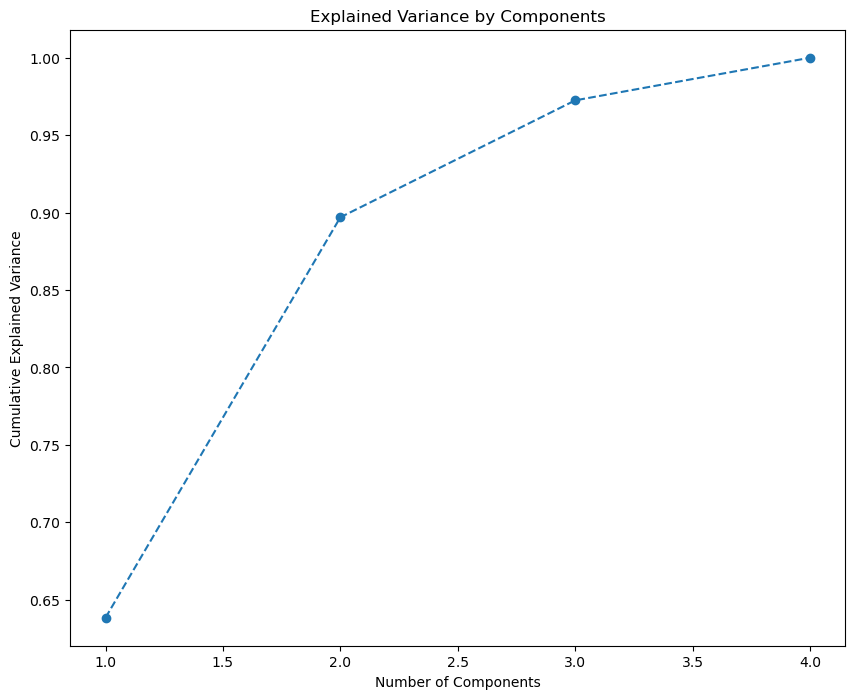

In [15]:
plt.figure(figsize = (10,8))
plt.plot(range(1,5), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

Choosing two components is sufficient here, as they preserve about 90 % of the variance.

In [16]:
# Choice of two components based on the above findings

pca = PCA(n_components = 2)

In [17]:
# Fit model to data

pca.fit(segmentation_std)

PCA(n_components=2)

In [18]:
# Extract calculated resulting components for our data set

pca.transform(segmentation_std)

array([[-1.33416694,  1.40472398],
       [-1.44396513,  1.29698326],
       [-1.52878898,  1.18313265],
       ...,
       [-1.12004806, -1.56588148],
       [-1.11621525, -1.67402179],
       [-1.10737429, -1.78126224]])

In [19]:
scores_pca = pca.transform(segmentation_std)

### 3. Examining data with elbow technique for k-means clustering

In [20]:
# Define range of potential clusters and define k-means clusters

num_cl = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in num_cl]

In [21]:
score = [kmeans[i].fit(scores_pca).score(scores_pca) for i in range(len(kmeans))]

In [22]:
score

[-12406.81390609188,
 -6131.628125109784,
 -4225.2993523681225,
 -3325.588912954201,
 -2607.773999560747,
 -2175.0497573866787,
 -1794.3685674089027,
 -1622.2919215104675,
 -1455.0309257773342,
 -1308.0420616297197,
 -1175.232936753911,
 -1042.2124843000634,
 -958.172716450453,
 -893.3272319384963,
 -836.2420729358072,
 -785.7263198264737,
 -747.3296382904929,
 -703.6735825412045,
 -665.9048397609292]

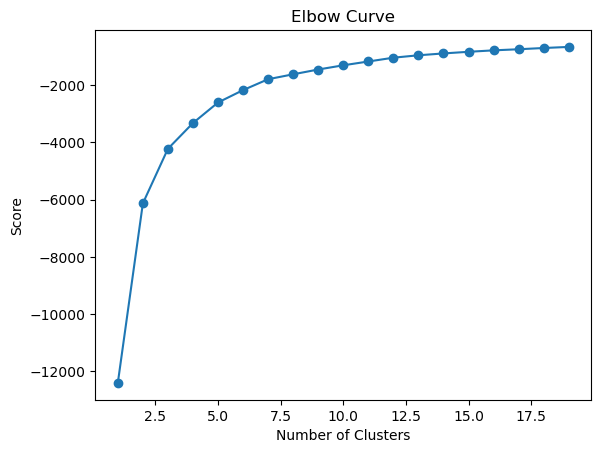

In [23]:
# Plot elbow curve

pl.plot(num_cl,score, marker = 'o')
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title ('Elbow Curve')
pl.show()

The curve becomes smoother after four clusters, which is thus the optimal count.

### 4. k-means clustering

In [24]:
# Create k-means object

kmeans = KMeans(n_clusters = 4)

In [25]:
kmeans.fit(scores_pca)

KMeans(n_clusters=4)

In [26]:
df_pca_kmeans = pd.concat([df.reset_index(drop=True),pd.DataFrame(scores_pca)], axis = 1)
df_pca_kmeans.columns.values[-2: ] = ['Component 1', 'Component 2']
df_pca_kmeans['Segment k-means PCA'] = kmeans.labels_

In [27]:
df_pca_kmeans.head()

year    hdi          gni  co2_consumption  Component 1  Component 2  \
0  1990  0.647  4742.215529         1.685726    -1.334167     1.404724   
1  1991  0.629  3358.087827         1.396741    -1.443965     1.296983   
2  1992  0.614  3080.746654         0.881990    -1.528789     1.183133   
3  1993  0.617  3538.885493         0.809166    -1.494038     1.073512   
4  1994  0.624  3940.312045         0.719588    -1.448212     0.959170   

   Segment k-means PCA  
0                    2  
1                    2  
2                    2  
3                    2  
4                    2

In [28]:
# Create a new Segment column for easier cluster readabilty

df_pca_kmeans['Segment'] = df_pca_kmeans['Segment k-means PCA'].map({0: 'first', 
                                                                    1: 'second', 
                                                                    2: 'third', 
                                                                    3: 'fourth'})

In [29]:
df_pca_kmeans.head()

year    hdi          gni  co2_consumption  Component 1  Component 2  \
0  1990  0.647  4742.215529         1.685726    -1.334167     1.404724   
1  1991  0.629  3358.087827         1.396741    -1.443965     1.296983   
2  1992  0.614  3080.746654         0.881990    -1.528789     1.183133   
3  1993  0.617  3538.885493         0.809166    -1.494038     1.073512   
4  1994  0.624  3940.312045         0.719588    -1.448212     0.959170   

   Segment k-means PCA Segment  
0                    2   third  
1                    2   third  
2                    2   third  
3                    2   third  
4                    2   third

In [30]:
df_pca_kmeans['Segment'].value_counts()

first     1120
third     1118
second     646
fourth     574
Name: Segment, dtype: int64

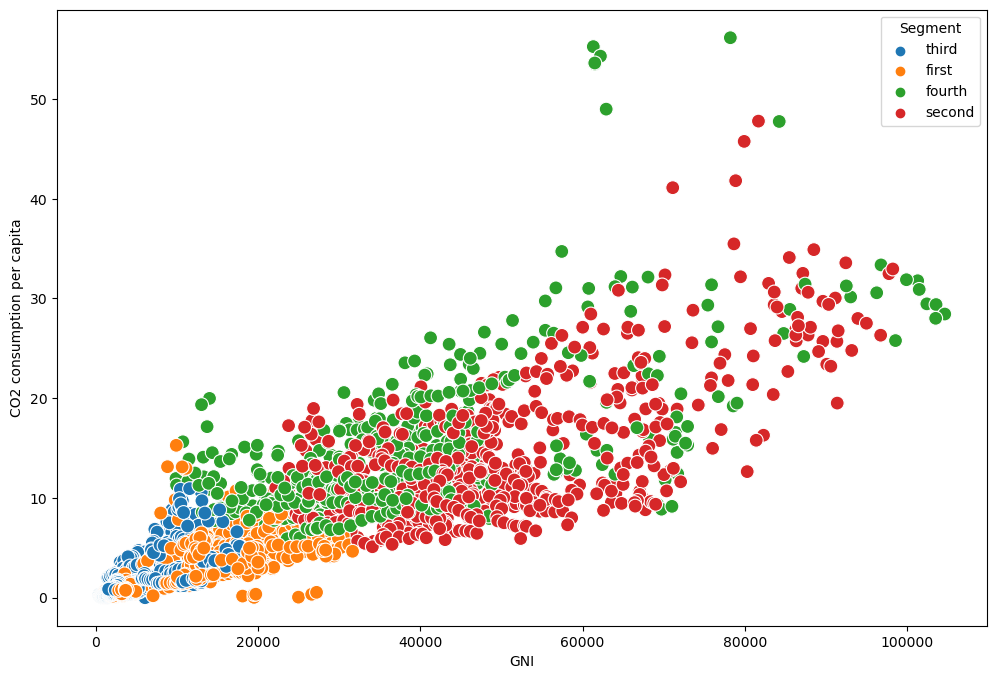

In [31]:
# Plot clusters for the 'GNI' and 'CO2 consumption' variables

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=df_pca_kmeans['gni'], y=df_pca_kmeans['co2_consumption'], hue=df_pca_kmeans['Segment'], s=100)
ax.grid(False)
plt.xlabel('GNI')
plt.ylabel('CO2 consumption per capita')
plt.show()

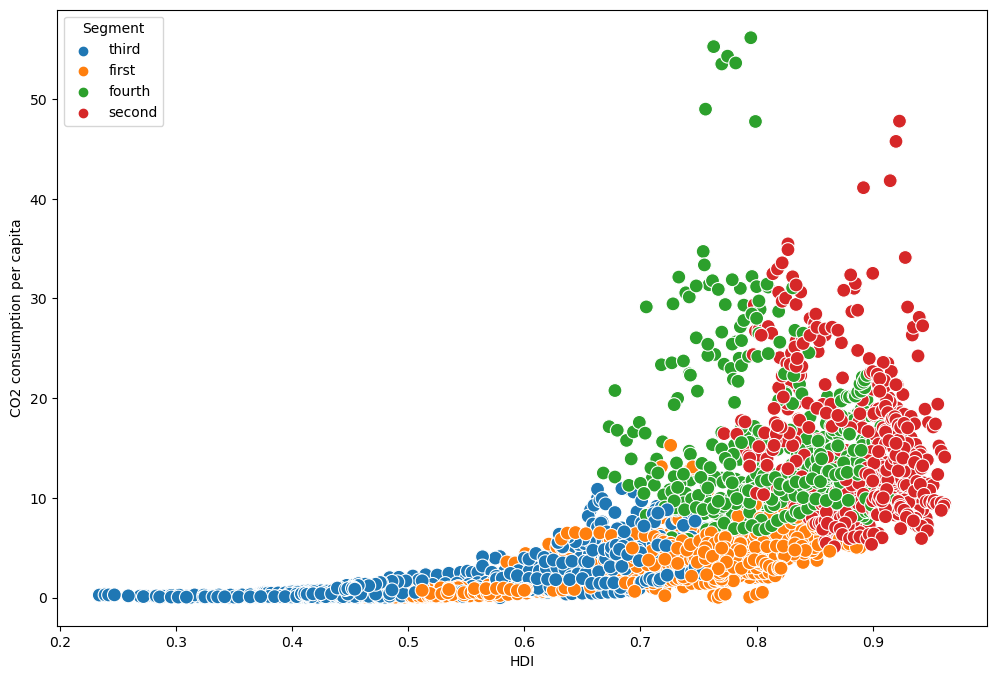

In [32]:
# Plot clusters for the 'HDI' and 'CO2 consumption' variables

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=df_pca_kmeans['hdi'], y=df_pca_kmeans['co2_consumption'], hue=df_pca_kmeans['Segment'], s=100)
ax.grid(False)
plt.xlabel('HDI')
plt.ylabel('CO2 consumption per capita')
plt.show()

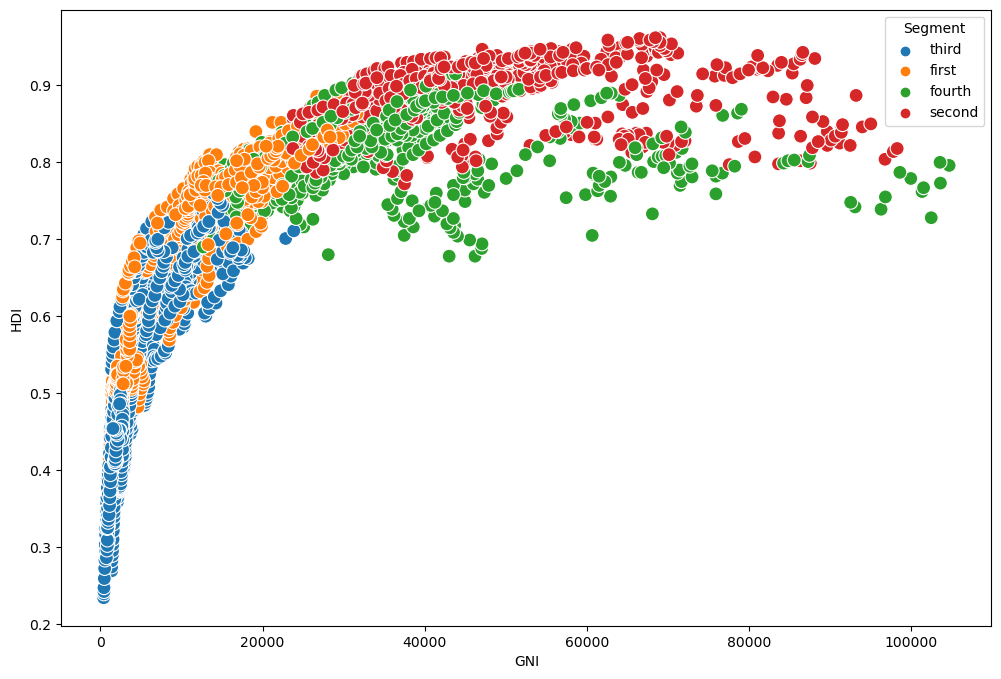

In [33]:
# Plot clusters for the 'GNI' and 'HDI' variables

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=df_pca_kmeans['gni'], y=df_pca_kmeans['hdi'], hue=df_pca_kmeans['Segment'], s=100)
ax.grid(False)
plt.xlabel('GNI')
plt.ylabel('HDI')
plt.show()

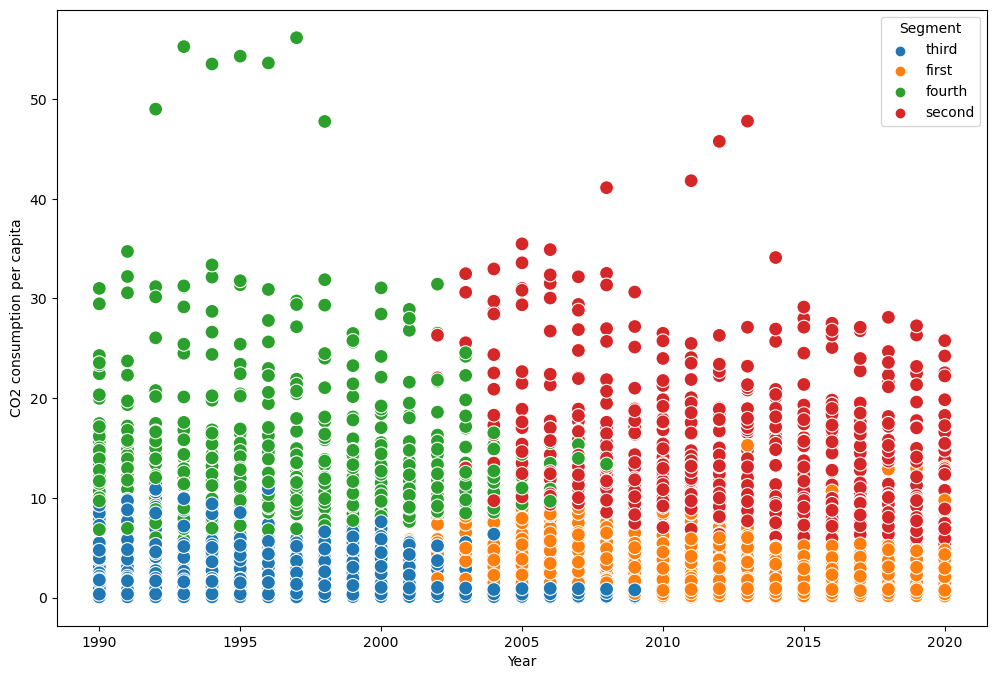

In [34]:
# Plot clusters for the 'Year' and 'co2_consumption' variables

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=df_pca_kmeans['year'], y=df_pca_kmeans['co2_consumption'], hue=df_pca_kmeans['Segment'], s=100)
ax.grid(False)
plt.xlabel('Year')
plt.ylabel('CO2 consumption per capita')
plt.show()

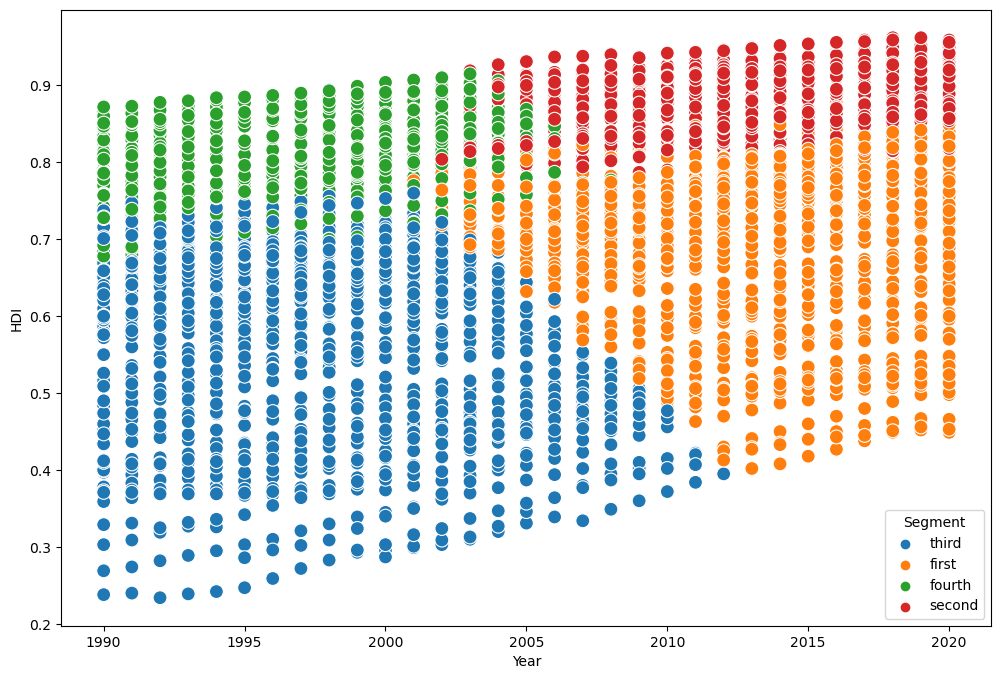

In [35]:
# Plot clusters for the 'Year' and 'HDI' variables

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=df_pca_kmeans['year'], y=df_pca_kmeans['hdi'], hue=df_pca_kmeans['Segment'], s=100)
ax.grid(False)
plt.xlabel('Year')
plt.ylabel('HDI')
plt.show()

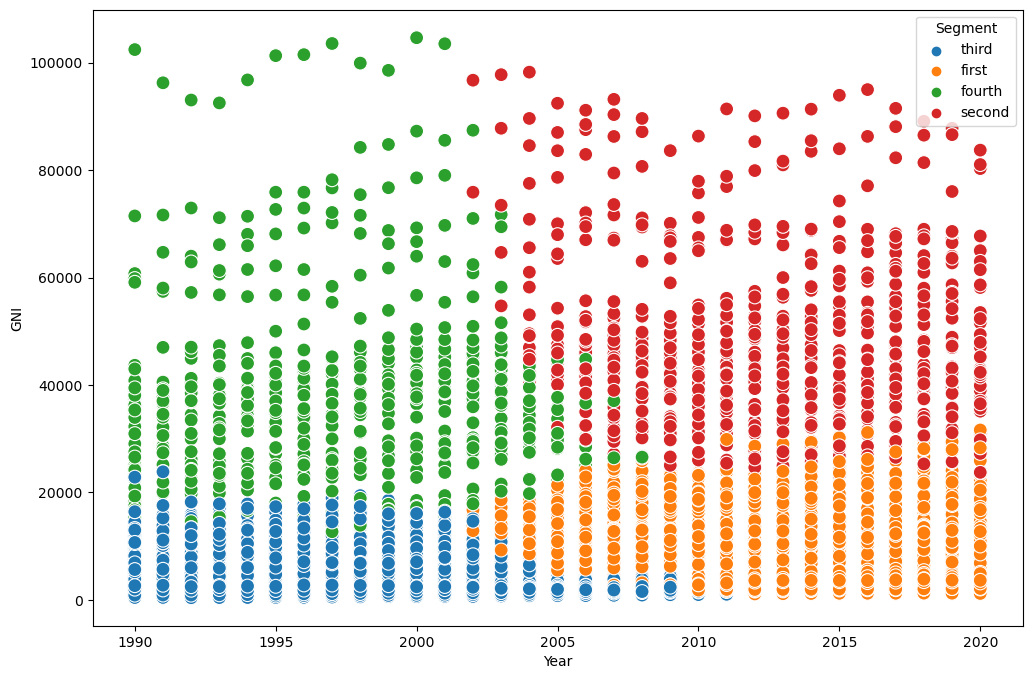

In [36]:
# Plot clusters for the 'Year' and 'GNI' variables

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=df_pca_kmeans['year'], y=df_pca_kmeans['gni'], hue=df_pca_kmeans['Segment'], s=100)
ax.grid(False)
plt.xlabel('Year')
plt.ylabel('GNI')
plt.show()

In [37]:
# Create a 3d scatterplot of 'HDI', 'GNI' and 'CO2 consumption' with plotly

fig = px.scatter_3d(df_pca_kmeans, x='hdi', y='gni', z='co2_consumption', color='Segment')
fig.update_traces(marker_size = 2)
fig.show()

In [38]:
# Create a 3d scatterplot of 'Year', 'HDI' and 'CO2 consumption' with plotly

fig = px.scatter_3d(df_pca_kmeans, x='year', y='hdi', z='co2_consumption', color='Segment')
fig.update_traces(marker_size = 2)
fig.show()

In [39]:
# Examine descriptive cluster statistics

df_pca_kmeans.groupby('Segment').agg({'year':['mean', 'median'],
                          'hdi':['mean', 'median'],
                          'gni':['mean', 'median'],
                          'co2_consumption':['mean', 'median']})

year               hdi                  gni                \
                mean  median      mean median          mean        median   
Segment                                                                     
first    2012.549107  2013.0  0.694751  0.719  11672.254258  10913.538635   
fourth   1997.254355  1997.0  0.815490  0.818  38195.117444  36520.340795   
second   2012.535604  2013.0  0.890043  0.898  49098.745352  46004.843650   
third    1997.990161  1998.0  0.558758  0.585   5993.863875   4625.816857   

        co2_consumption             
                   mean     median  
Segment                             
first          3.080307   2.402273  
fourth        14.175269  12.034629  
second        14.071422  12.189338  
third          1.898292   1.105822

In [40]:
df_pca_kmeans['Segment'].value_counts()

first     1120
third     1118
second     646
fourth     574
Name: Segment, dtype: int64

A few exploratory facts become apparent in the above scatterplors and descriptive statistics:

1. Two clusters respectively appear to group together earlier and later years: The first and fourth have their mean and median in the early 2010s, and second and third cluster in the late 1990s.


2. The second and first cluster appear to contain the "less developed" countries, in earlier and later years. The same appears to apply to the "more developed" countries in the fourth and third clusters.


3. The third cluster comprises the lowest stats for HDI, GNI and CO2 values. The first cluster contains measurably higher HDI and GNI values, and slightly higher stats for CO2. Could that be indicative that while HDI and GNI of the "less developed" countries slightly increased over time, so did their CO2 footprint?


4. The fourth cluster is interesting because it contains the highest HDI and GNI values, but lower CO2 consumption than the second cluster (which contains the highest CO2). Could that be indicative that while HDI and GNI of the "more developed" countries over time, some managed to lower their CO2 footprint?